In [1]:
from windisch import *
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
#update_input_parameters()
tip = TurbinesInputParameters()
tip.static()
#tip.stochastic(3)
_, array = fill_xarray_from_input_parameters(
    tip,
    scope={"year": [2020, ], "size": [1000,]}
)

In [3]:
fp = "/Users/romain/GitHub/windisch/dev/era5_mean_2013-2022_month_by_hour_corrected.nc"

In [7]:
wt = WindTurbineModel(
    array,
    location=(55.602164360115104, 12.491974627997108),
    wind_data=xr.open_dataset(fp),
    #country="DK"
)

Fetching terrain data only.
Using cached data for location (55.602164360115104, 12.491974627997108)
Onshore wind turbines


In [8]:
wt.terrain_vars

<xarray.Dataset> Size: 281kB
Dimensions:      (time: 8784, height: 3)
Coordinates:
  * height       (height) float32 12B 50.0 100.0 200.0
  * time         (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
Data variables:
    WS           (time, height) float64 211kB 7.6 8.88 10.38 ... 8.778 10.3
    spatial_ref  int32 4B 0
    LANDMASK     float64 8B 1.0
    TKE          float32 4B 1.879
    crs          int8 1B 0
    RHO          float32 4B 1.245

In [9]:
wt.set_all()

In [15]:
wt["cut off"]

KeyError: "not all values found in index 'parameter'. Try setting the `method` keyword argument (example: method='nearest')."

In [13]:
wt.power_curve.sel(application="onshore")

<xarray.DataArray (size: 1, year: 1, value: 1, wind speed: 31)> Size: 248B
array([[[[   0.        ,    0.        ,    0.        ,    8.43263728,
            42.30015392,   94.74674925,  164.01693712,  260.45282145,
           388.780888  ,  553.55716279,  759.33767187, 1000.        ,
          1000.        , 1000.        , 1000.        , 1000.        ,
          1000.        , 1000.        , 1000.        , 1000.        ,
          1000.        , 1000.        , 1000.        , 1000.        ,
          1000.        , 1000.        , 1000.        , 1000.        ,
          1000.        , 1000.        , 1000.        ]]]])
Coordinates:
  * size         (size) int64 8B 1000
    application  <U8 32B 'onshore'
  * year         (year) int64 8B 2020
  * value        (value) int64 8B 0
  * wind speed   (wind speed) int64 248B 0 1 2 3 4 5 6 ... 24 25 26 27 28 29 30

In [6]:
wt["lifetime electricity production"]

<xarray.DataArray (size: 1, application: 2, year: 1, value: 1)> Size: 16B
array([[[[1.24352544e+08]],

        [[8.65276409e+07]]]])
Coordinates:
  * size         (size) int64 8B 1000
  * application  (application) <U8 64B 'offshore' 'onshore'
    parameter    <U36 144B 'lifetime electricity production'
  * year         (year) int64 8B 2020
  * value        (value) int64 8B 0

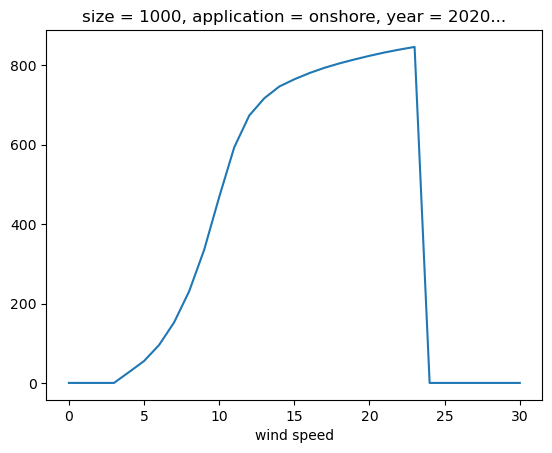

In [7]:
wt.power_curve.sel(application="onshore", year=2020).plot()

In [9]:
wt["average load factor"]

<xarray.DataArray (size: 1, application: 2, year: 1, value: 1)> Size: 16B
array([[[[       nan]],

        [[0.13575508]]]])
Coordinates:
  * size         (size) int64 8B 1000
  * application  (application) <U8 64B 'offshore' 'onshore'
    parameter    <U36 144B 'average load factor'
  * year         (year) int64 8B 2020
  * value        (value) int64 8B 0

In [1]:
from windisch import *
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)

In [2]:
dk = pd.read_excel("/Users/romain/GitHub/windisch/dev/danish_wind_turbine_registry.xlsx", header=13)

In [3]:
dk = dk.iloc[:, [3, 12, 13, 55, 56, 57, 58, 59, 60, 61]]
dk.columns = [
    "Power (kW)",
    "X",
    "Y",
    "Production 2017",
    "Production 2018",
    "Production 2019",
    "Production 2020",
    "Production 2021",
    "Production 2022",
    "Production 2023"
]
dk["Production"] = dk[[
    "Production 2017",
    "Production 2018",
    "Production 2019",
    "Production 2020",
    "Production 2021",
    "Production 2022",
    "Production 2023"
]].mean(skipna=True, axis=1)

dk = dk.loc[dk["Production"] > 1e3]
dk = dk.loc[dk["X"] > 0]
dk = dk.loc[dk["Power (kW)"] > 100]

dk["Load factor"] = dk["Production"] / (dk["Power (kW)"] * 8760)

In [4]:
dk = dk.sort_values(by="Power (kW)", ascending=False)

In [5]:
# Convert X, Y to Longitude (LON) and Latitude (LAT)
def convert_to_lat_lon(row):
    if pd.notnull(row['X']) and pd.notnull(row['Y']):
        lon, lat = transformer.transform(row['X'], row['Y'])
        return pd.Series([lon, lat])
    else:
        return pd.Series([None, None])

dk[['LAT', 'LON']] = dk.apply(convert_to_lat_lon, axis=1)

In [6]:
import numpy as np
fp = "/Users/romain/GitHub/windisch/dev/era5_mean_2013-2022_month_by_hour_corrected.nc"
def get_load_factor(row):
    models = [
        "Slootweg et al. 2003",
        "Heier 2009",
        "Thongam et al. 2009",
        "De Kooning et al. 2010",
        "Ochieng et Manyonge 2014",
        "Dai et al. 2016",
    ]

    load_factors = []

    for model in models:
        tip = TurbinesInputParameters()
        tip.static()
        _, array = fill_xarray_from_input_parameters(
            tip,
            scope={"year": [2020, ],}
        )
        array = array.interp(size=[row["Power (kW)"]], kwargs={"fill_value": "extrapolate"},)
        wt = WindTurbineModel(
            array,
            location=(row["LON"], row["LAT"]),
            wind_data=xr.open_dataset(fp),
            power_curve_model=model
        )
        wt.set_all()
        load_factors.append(np.squeeze(np.nan_to_num(wt["average load factor"].values, 0)).max().item(0))
    return load_factors


In [ ]:
dk[[
    "Slootweg et al. 2003",
    "Heier 2009",
    "Thongam et al. 2009",
    "De Kooning et al. 2010",
    "Ochieng et Manyonge 2014",
    "Dai et al. 2016"
]] = None
columns_to_check = [
    "Production 2017", "Production 2018", "Production 2019",
    "Production 2020", "Production 2021", "Production 2022", "Production 2023"
]

# Filter rows where all the specified columns have non-NaN values
dk = dk.dropna(subset=columns_to_check, how="any")

# dk.iloc[:2, -6:] = dk.iloc[:2, :].apply(get_load_factor, axis=1)
# Assuming get_load_factor(row) returns a list of 6 floats
rows = 2000
dk.iloc[:rows, -6:] = pd.DataFrame(dk.iloc[:rows, :].apply(get_load_factor, axis=1).to_list(), index=dk.index[:rows])


Fetching terrain data only.
Using cached data for location (55.45280520510544, 8.510371088004975)
Offshore wind turbines
Fetching terrain data only.
Using cached data for location (55.45280520510544, 8.510371088004975)
Offshore wind turbines
Fetching terrain data only.
Using cached data for location (55.45280520510544, 8.510371088004975)
Offshore wind turbines
Fetching terrain data only.
Using cached data for location (55.45280520510544, 8.510371088004975)
Offshore wind turbines
Fetching terrain data only.
Using cached data for location (55.45280520510544, 8.510371088004975)
Offshore wind turbines
Fetching terrain data only.
Using cached data for location (55.45280520510544, 8.510371088004975)
Offshore wind turbines
Fetching terrain data only.
Using cached data for location (55.451929604605624, 8.518429780308034)
Onshore wind turbines
Fetching terrain data only.
Using cached data for location (55.451929604605624, 8.518429780308034)
Onshore wind turbines
Fetching terrain data only.
Usin

In [ ]:
dk.to_excel("CF_prediction.xlsx")

In [ ]:
dk

Slootweg et al. 2003 Mean Absolute Percentage Error (MAPE): 10.78%
Heier 2009 Mean Absolute Percentage Error (MAPE): 9.44%
Thongam et al. 2009 Mean Absolute Percentage Error (MAPE): 15.69%
De Kooning et al. 2010 Mean Absolute Percentage Error (MAPE): 10.72%
Ochieng et Manyonge 2014 Mean Absolute Percentage Error (MAPE): 9.44%
Dai et al. 2016 Mean Absolute Percentage Error (MAPE): 12.89%


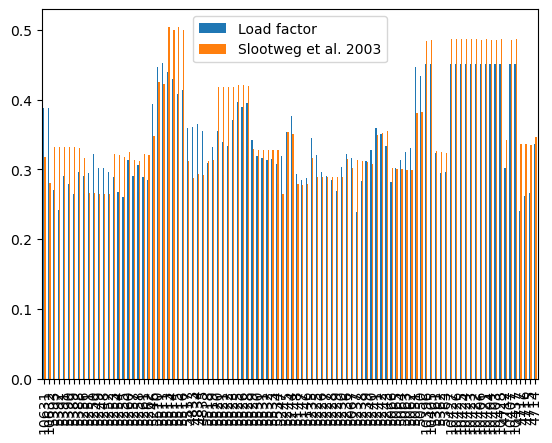

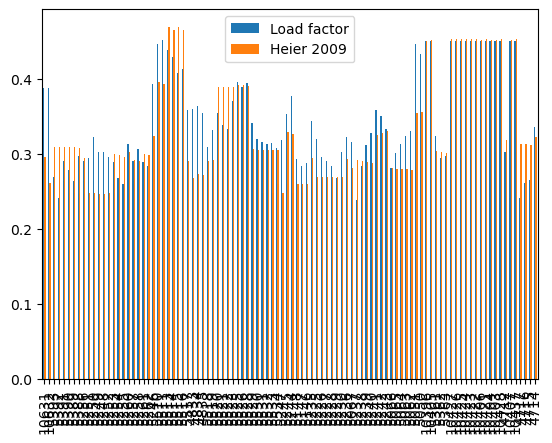

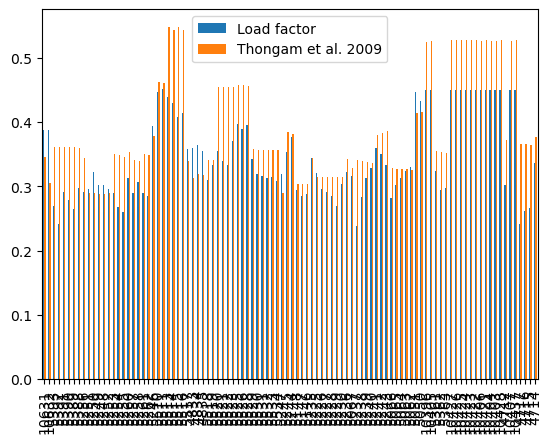

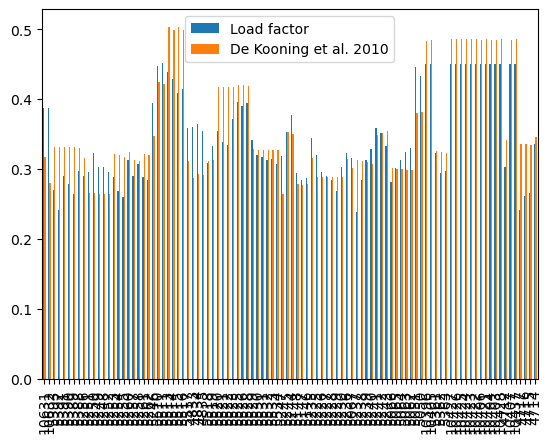

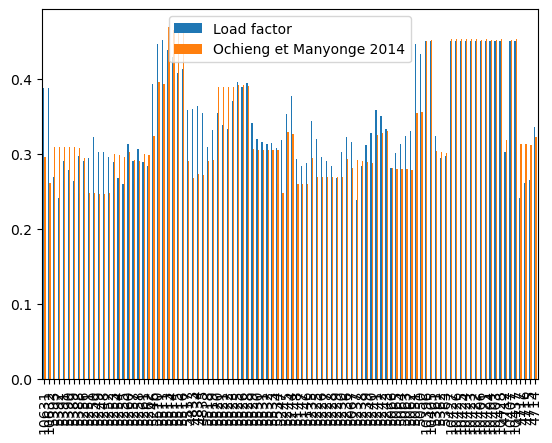

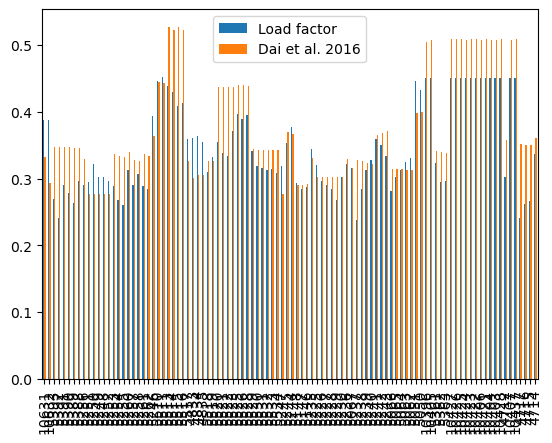

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

models = [
    "Slootweg et al. 2003",
    "Heier 2009",
    "Thongam et al. 2009",
    "De Kooning et al. 2010",
    "Ochieng et Manyonge 2014",
    "Dai et al. 2016",
]

for model in models:

    # Extract the actual and predicted load factors
    actual = dk["Load factor"]
    predicted = dk[model]
    
    # Drop rows where either value is NaN
    mask = ~actual.isna() & ~predicted.isna() & actual > 0
    actual = actual[mask]
    predicted = predicted[mask]
    
    # Compute metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # In percentage
    r2 = r2_score(actual, predicted)
    
    # Display the metrics
    #print(f"Mean Absolute Error (MAE): {mae:.4f}")
    #print(f"Mean Squared Error (MSE): {mse:.4f}")
    #print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"{model} Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print(f"R² (Coefficient of Determination): {r2:.4f}")
    dk.loc[dk[model] > 0, ["Load factor", model]].plot(kind="bar")


In [9]:
dk

,Power (kW),X,Y,Production 2017,Production 2018,Production 2019,Production 2020,Production 2021,Production 2022,Production 2023,Production,Load factor,LAT,LON,Slootweg et al. 2003,Heier 2009,Thongam et al. 2009,De Kooning et al. 2010,Ochieng et Manyonge 2014,Dai et al. 2016
126,550.0,651502.14,6063736.82,1.052915e+06,7.861834e+05,5.486083e+05,9.720462e+05,7.566960e+05,1.028113e+06,9.990504e+05,8.776589e+05,0.207358,11.350988,54.698121,0.16976,0.158127,0.184679,0.169508,0.158127,0.177584
123,550.0,650982.72,6063943.94,1.159037e+06,9.178330e+05,1.050238e+06,1.073924e+06,1.606268e+05,5.652306e+05,1.051255e+06,8.540206e+05,0.218193,11.343042,54.700137,0.168906,0.157331,0.183749,0.168654,0.157331,0.17669
676,550.0,677825.07,6087308.59,1.264019e+06,1.037441e+06,1.146789e+06,1.166704e+06,9.942645e+05,1.112872e+06,1.087185e+06,1.115611e+06,0.225651,11.773433,54.901102,0.196142,0.1827,0.213379,0.19585,0.1827,0.205182
677,550.0,677830.67,6087156.56,1.332692e+06,1.082480e+06,1.248162e+06,1.190312e+06,1.028937e+06,1.104627e+06,1.008226e+06,1.142205e+06,0.209262,11.773427,54.899735,0.195368,0.181979,0.212536,0.195077,0.181979,0.204372
775,550.0,648892.75,6132580.14,1.029505e+06,8.732544e+05,9.923434e+05,9.730727e+05,7.301668e+05,8.616032e+05,9.077490e+05,9.096706e+05,0.188408,11.346360,55.317043,0.17443,0.162476,0.189758,0.17417,0.162476,0.182469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5392,6000.0,454455.91,6227232.51,1.691074e+07,1.351574e+07,1.281038e+07,1.104800e+07,7.788710e+06,1.254838e+07,1.270909e+07,1.247586e+07,0.241802,8.266179,56.187878,None,None,None,None,None,None
5393,6000.0,454283.34,6227493.77,1.743125e+07,1.394537e+07,1.385049e+07,1.134359e+07,8.461150e+06,1.432859e+07,1.419402e+07,1.336492e+07,0.270054,8.263353,56.190208,None,None,None,None,None,None
5391,6000.0,454635.85,6226960.92,1.708746e+07,1.353214e+07,1.270737e+07,1.130340e+07,8.604240e+06,1.361101e+07,1.528509e+07,1.316153e+07,0.290812,8.269124,56.185455,None,None,None,None,None,None
10631,8000.0,469033.00,6145290.00,3.116791e+07,1.866734e+07,2.979924e+07,3.084873e+07,2.583465e+07,2.887288e+07,2.719114e+07,2.748313e+07,0.388001,8.510371,55.452805,None,None,None,None,None,None


In [21]:
import xarray as xr

ds = xr.open_dataset("/Users/romain/GitHub/windisch/dev/era5_mean_2013-2022_month_by_hour.nc")
corr = xr.open_dataset("/Users/romain/GitHub/windisch/dev/ratio_gwa2_era5.nc")

In [23]:
ds.sum()

<xarray.Dataset> Size: 108B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
    variable     <U23 92B 'ratio_gwa2_era5_mean_WS'
Data variables:
    wind_speed   float64 8B 1.957e+08

In [18]:
ds.coords

Coordinates:
  * hour         (hour) int16 48B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * longitude    (longitude) float32 804B -15.0 -14.75 -14.5 ... 34.5 34.75 35.0
  * height       (height) float32 12B 50.0 100.0 200.0
  * latitude     (latitude) float32 596B 35.0 35.25 35.5 ... 71.5 71.75 72.0
  * month        (month) int16 24B 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 8B ...
    variable     <U23 92B 'ratio_gwa2_era5_mean_WS'

In [22]:
ds *= corr.to_array().sel(variable='ratio_gwa2_era5_mean_WS').interp(
    longitude=ds.coords["longitude"],
    latitude=ds.coords["latitude"],
    method="linear"
)

In [25]:
ds.to_netcdf("/Users/romain/GitHub/windisch/dev/era5_mean_2013-2022_month_by_hour_corrected_2.nc")

In [9]:
ds.coords

Coordinates:
  * hour         (hour) int16 48B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
  * longitude    (longitude) float32 804B -15.0 -14.75 -14.5 ... 34.5 34.75 35.0
  * height       (height) float32 12B 50.0 100.0 200.0
  * latitude     (latitude) float32 596B 35.0 35.25 35.5 ... 71.5 71.75 72.0
  * month        (month) int16 24B 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref  int64 8B ...
    variable     <U23 92B 'ratio_gwa2_era5_mean_WS'

<Axes: xlabel='size,application'>

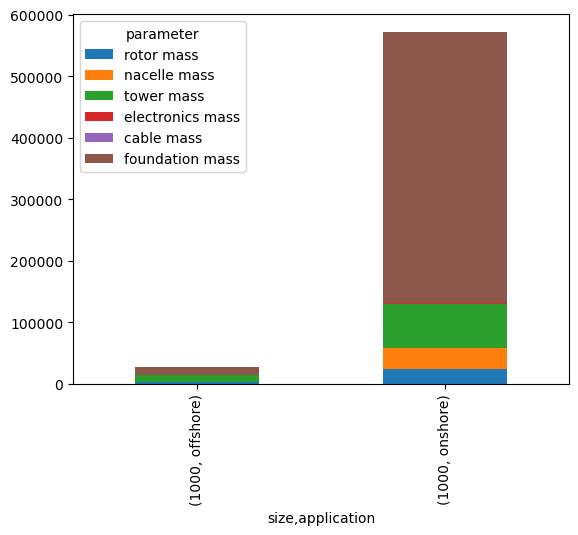

In [7]:
list_mass = [
    "rotor mass",
    "nacelle mass",
    "tower mass",
    "electronics mass",
    "cable mass",
    "foundation mass",
]
wt.array.sel(year=2020, value=0, parameter=list_mass).to_dataframe("val").unstack()["val"].plot(kind="bar", stacked=True)

In [24]:
wt.array.coords

Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
  * parameter    (parameter) <U36 'access road' ... 'turbines per farm'
  * year         (year) int64 2000 2010 2020 2030 2040 2050
  * value        (value) int64 0

In [22]:
wt.array.sel(year=2020, value=0, parameter="maintenance transport").to_dataframe("val").unstack()["val"]

application,offshore,onshore
size,,
1000kW,256779.661017,6250.0
100kW,0.000000,6250.0
3000kW,256779.661017,6250.0
500kW,0.000000,6250.0
8000kW,256779.661017,6250.0


<AxesSubplot: >

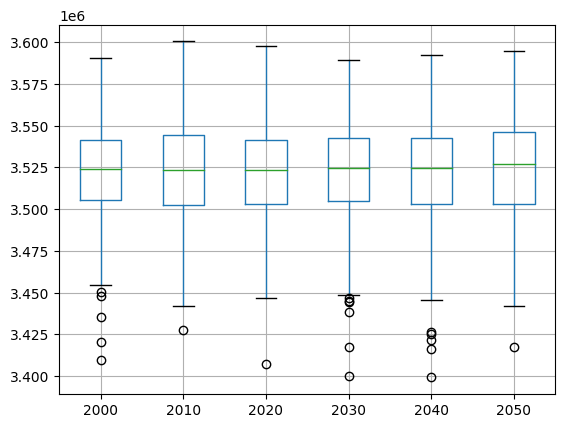

In [34]:
wt.array.sel(parameter="total mass", application="offshore", size="8000kW").to_dataframe("val").unstack()["val"].T.boxplot()

In [6]:
from windisch.model import func_tower_weight_d2h
func_tower_weight_d2h(5, 10, 3.03584782e-04, 9.68652909e00)

9762.425285500001

In [7]:
func_tower_weight_d2h(wt["rotor diameter"], wt["tower height"], 3.03584782e-04, 9.68652909e00)

<xarray.DataArray (size: 5, application: 2, year: 6, value: 1)>
array([[[[ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306],
         [ 73374.90009306]],

        [[ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994],
         [ 72712.91953994]]],


       [[[  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
         [  9686.52909   ],
...
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168],
         [ 30434.02672168]]],


       [[[840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929],
         [840467.97204929]],

        [[754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841],
         [754455.95551841]]]])
Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
  * year         (year) int64 2000 2010 2020 2030 2040 2050
  * value        (value) int64 0
    tower mass   (size, application, year, value) float64 7.337e+04 ... 7.545...

In [6]:
wt.array.sel(year=2020, value=0, parameter="tower mass")

<xarray.DataArray (size: 5, application: 2)>
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * size         (size) <U6 '1000kW' '100kW' '3000kW' '500kW' '8000kW'
  * application  (application) <U8 'offshore' 'onshore'
    parameter    <U36 'tower mass'
    year         int64 2020
    value        int64 0